### Library import

In [1]:
import sys
import os
import serial
import csv
import time
import pandas as pd
import functools
import numpy as np
import random as rd
import matplotlib
import threading

import seaborn as sns
from scipy.stats import gaussian_kde
from numpy import diff
                
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.pyplot import figure

plt.rcParams["figure.figsize"] = (20,3)

### Data reading from storage file

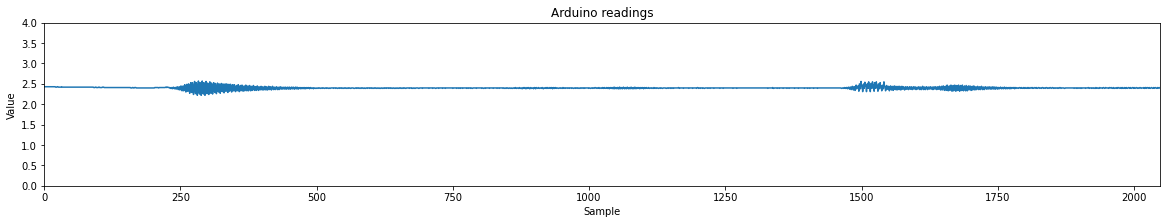

In [2]:
df = pd.read_csv('captured_data/test.csv', header=None, dtype={'Voltages': float}) #read csv file
df = df.replace('\r\n', '', regex = True)
df.drop(df[df[0].str.len() != 4].index, inplace=True)
#df.drop(df[df[0] == ''].index, inplace=True)

x = df[0].to_numpy().astype(float)
y = np.arange(0, len(x))

plt.plot(y, x)
plt.title('Arduino readings')
plt.ylim([0, 4])
plt.xlim([0,2048])
plt.xlabel('Sample')
plt.ylabel('Value')

plt.show()

### Functions

In [4]:
def echo_distance(echo_sample_value, pulse_sample_value):
    #pulse_origin = 300
    threshold_values = echo_sample_value-pulse_sample_value
    air_speed = 343
    sample_freq = 140000

    distance = (1/sample_freq)*threshold_values*air_speed/2
    
    return(distance)

In [14]:
def echo_center_point(sample):
    sample_mean = 1#sample.mean()
    pulse_window = 15
    overshoot_confidence = 1.15
    echo_values = []
    pulse_values = []
    echo_center = []
    for i in range(len(sample)):
        sample_window = sample[i:i+pulse_window]
        window_mean = sum(sample_window)/len(sample_window)
        if window_mean > sample_mean*overshoot_confidence:
            if i > 500:
                echo_values.append(i)
            else:
                pulse_values.append(i)

    #print(echo_values)
    pulse_center = int(sum(pulse_values)/len(pulse_values))
    pulse_width = int(len(pulse_values)*0.4)
    for i in range(0, round(len(echo_values)/pulse_width)):
        temp_values = echo_values[pulse_width*(i):pulse_width*(i+1)]
        temp_center = sum(temp_values)/len(temp_values) 
        echo_center.append(int(temp_center))
        
    return(echo_center, pulse_center)

In [124]:
def echo_center_point(sample, threshold):
    
    pulse_window = 7 # Number of samples to compute
    
    echo_values = [] # Sample indexes that meet the threshold (for the received echoes)
    echo_center = [] # Sample indexes for echoes - preprocessed

    pulse_values = [] # Sample indexes that meet the threshold (for the initial pulse)
    pulse_mean_values = [] # Mean values for the computed sample window
    
    
    for i in range(len(sample)):       
        sample_window = sample[i:i+pulse_window]    # Samples within desired window
        window_mean = sum(sample_window)/len(sample_window)  # Window mean value
        if window_mean > threshold: 
            if i > 500:                # index 500 represents the minimum distance a echo pulse could be find
                echo_values.append(i)   # Save the sample index if the sample mean meets the threshold and the index is bigger than 500.
            else:
                pulse_values.append(i)  # For idx smaller than 500 a initial pulse should be existing
                pulse_mean_values.append(window_mean) # Save the sample mean values
                
                
    pulse_idx = pulse_mean_values.index(max(pulse_mean_values)) # Index for the maximum value reached by the pulse
    pulse_center = pulse_values[pulse_idx] # Sample index for the initial pulse center (triggered by the sensor)
    
    pulse_width = 80 #int(len(pulse_values)*0.4)  # Define the maximum width for the pulse
    
    for i in range(0, round(len(echo_values)/pulse_width)):
        temp_values = echo_values[pulse_width*(i):pulse_width*(i+1)]  # Echoes values within the pulse width
        temp_center = sum(temp_values)/len(temp_values)  # Compute the pulse center as the mean within the pulse width
        echo_center.append(int(temp_center))  # Save echoes center
        
    return(echo_center, pulse_center)

In [125]:
echo_center_point(sample, threshold)

([1529, 1684], 290)

### Data cleaning and transformation

- Derivate and noise reduction
    - Derivate the initial raw data. The new ground value will be 0
    - Take absolute value after de derivate to only use positive values. (Usefull in next steps to calculate more precise mean metric)
    - Get rid all the values below certain threshold, to eliminate all the remaining noise after the derivate

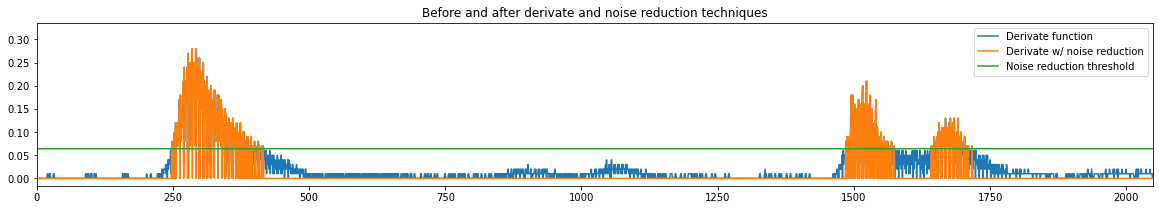

In [137]:
## Derivate

dx = 1 # Define derivate step
dy = np.abs(diff(x)/dx) # Derivate the raw data and take absolute value

plt.plot(np.arange(0, len(dy)), dy, label = 'Derivate function')  # Plot the derivate function

### Noise reduction

limit = max(dy)  # Calculate max value
threshold = 0.2  # Set threshold value
dy = [0 if (val < threshold*limit) else val for val in dy]  # All values below (threshold*limit) will be turned into 0 

plt.plot(np.arange(0, len(dy)), dy, label = "Derivate w/ noise reduction")
plt.plot(np.arange(0, len(dy)), [threshold*limit for i in range(len(dy))], label = "Noise reduction threshold")


[threshold*limit for i in range(len(dy))]
### Plot results

plt.title('Before and after derivate and noise reduction techniques')
plt.xlim([0,2048])
plt.legend(loc = 'upper right')
plt.show()

Pulse center point:  294
Echo center point:  [1543, 1643, 1725]
Echo distance 0 -> 1.530025 [m]
Echo distance 1 -> 1.652525 [m]
Echo distance 2 -> 1.752975 [m]


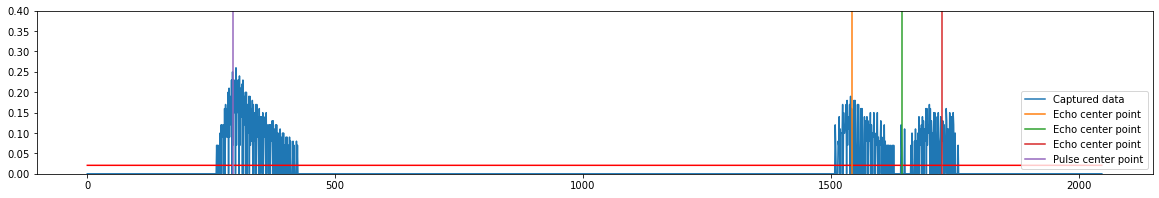

In [129]:
init_val = 6146
n_samples = 1
sample = dy[init_val:init_val+(n_samples*2048)]

#sample = np.exp(sample)**5 - 1
ax_y = np.arange(0, len(sample))


#plt.xlim([0, 2048])
plt.plot(ax_y, sample, label = "Captured data")


#confidence threshold
threshold = 0.08*max(sample)
confidence_threshold = [threshold for i in range(len(sample))]
plt.plot(ax_y,confidence_threshold, color = 'red')

#echo center
echo_plot_y = [i for i in range(2)]
center_point = echo_center_point(sample, threshold)[0]

for i in range(len(center_point)): 
    echo_plot_x = [center_point[i] for j in range(len(echo_plot_y))]
    plt.plot(echo_plot_x, echo_plot_y, label = 'Echo center point')


#pulse center
center_point_pulse = int(echo_center_point(sample, threshold)[1])
echo_plot_x = [center_point_pulse for i in range(len(echo_plot_y))]
plt.plot(echo_plot_x, echo_plot_y, label = 'Pulse center point')



plt.legend(loc = "lower right")

print('Pulse center point: ', center_point_pulse)
print('Echo center point: ', center_point)
i = 0
for echo_point in center_point:
    print('Echo distance', i, '->' , echo_distance(echo_point, center_point_pulse), '[m]')
    i += 1
plt.ylim([0, 0.4])
plt.show()

In [ ]:
''' This part is intended to amplify the raw signal from R8 resistor. 
This is signal is the input of a comparator. A vcc/2 signal is used to compare.
So our signal is shifted 2.5V, therefore we need to substract that value to read more correctly the values from the ADC
'''
init_val = 2048
n_samples = 1
sample = x[init_val:init_val+(n_samples*2048)]

sample = np.exp(sample - sample.mean())**10

ax_x = sample
ax_y = np.arange(0, len(sample))

init_val = 0
n_samples = 1
sample = dy[init_val:init_val+(n_samples*2048)]

sample = np.exp(sample)**5
ax_x = sample
ax_y = np.arange(0, len(sample))


#plt.xlim([0, 2048])
plt.plot(ax_y, ax_x, label = "Without filtering")

#Mean filter
i = 0
for n_sample in sample:
    
    if i == 0:
        sample[i] = (sample[i] + sample[i+1] )/2
    elif i == len(sample)-1:
        sample[i] = (sample[i] + sample[i-1])/2
    else:
        sample[i] = (sample[i-1] + sample[i] + sample [i+1] )/ 3
    
    i+=1

ax_x = sample
#plt.xlim([0, 2048])
plt.plot(ax_y, ax_x, label = "With filtering")

#confidence threshold
threshold_mean = sample.mean()*1.15
confidence_threshold = [threshold_mean for i in range(len(sample))]
plt.plot(ax_y,confidence_threshold, color = 'red')


#echo center
echo_plot_y = [i for i in range(7)]
center_point = echo_center_point(sample)[0]

#pulse center
center_point_pulse = int(echo_center_point(sample)[1])
echo_plot_x = [center_point_pulse for i in range(len(echo_plot_y))]
plt.plot(echo_plot_x, echo_plot_y, label = 'Pulse center point')



for i in range(len(center_point)): 
    echo_plot_x = [center_point[i] for j in range(len(echo_plot_y))]
    plt.plot(echo_plot_x, echo_plot_y, label = 'Echo center point')


plt.legend(loc = "lower right")

print('Pulse center point: ', center_point_pulse)
print('Echo center point: ', center_point)
i = 0
for echo_point in center_point:
    print('Echo distance', i, '->' , echo_distance(echo_point, center_point_pulse), '[m]')
    i += 1

plt.show()

### Transformation tests

In [ ]:
##KALMAN FILTER TEST
print(sample)
print(kalman_filter(sample))

ax_x = sample
ax_y = np.arange(0, len(sample))

plt.subplot(2,1,1)

plt.plot(ax_y, ax_x, label = "Without filtering")
plt.plot(ax_y, kalman_filter(ax_x), label = "Kalman filter")

plt.legend()

plt.subplot(2,1,2)
plt.plot(ax_y, kalman_filter(ax_x), label = "Kalman filter")
plt.legend()
plt.show()

In [ ]:
init_val = 2048
n_samples = 1
sample = x[init_val:init_val+(n_samples*2048)]

kalman = kalman_filter(sample)

plt.plot(ax_y, kalman, label = "Kalman")

sample = (np.exp(sample - sample.mean())-1)*30

ax_x = sample
ax_y = np.arange(0, len(sample))
#plt.xlim([0, 2048])
#plt.plot(ax_y, ax_x, label = "Without filtering")

#Mean filter
i = 0
for n_sample in sample:
    
    if i == 0:
        sample[i] = (sample[i] + sample[i+1] )/2
    elif i == len(sample)-1:
        sample[i] = (sample[i] + sample[i-1])/2
    else:
        sample[i] = (sample[i-1] + sample[i] + sample [i+1] )/ 3
    
    i+=1

ax_x = sample*2
#plt.plot(ax_y, ax_x, label = "With filtering")

plt.legend(loc = "lower right")
plt.show()